In [ ]:
"""
Import libraries that require
"""
%pip install auto-sklearn
from autosklearn.experimental.askl2 import AutoSklearn2Classifier
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split

plt.rcParams['font.sans-serif'] = ['Times New Roman']
sns.set_style("whitegrid")
sns.set_style({'font.family':'serif', 'font.serif':'Times New Roman'})
sns.set(font_scale=1.2)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
# !pip install /content/gdrive/Shareddrives/520_Project/en_vectors_web_lg-2.1.0.tar.gz
# import en_vectors_web_lg

Mounted at /content/gdrive


# Load Dataset

In [ ]:
data = pd.read_csv(os.path.join('/content/gdrive/Shareddrives/520_Project', "Womens_Clothing_E-Commerce_Reviews.csv"))
data.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


Choose "Review text" as features, and "Recommended IND" as labels. Split the data into training(80%), validation(10%) and testing sets(10%).

In [ ]:
# Split the data into training, validation and testing sets

# Output: X_train, X_test; y_train, y_test.
X_train, X_test, y_train, y_test = train_test_split(np.array(data['Review Text'].fillna(' ')), np.array(data['Recommended IND']), test_size=0.1, random_state=42)

print("Number of data points in training, validation and testing set:", X_train.shape[0], X_test.shape[0])

Number of data points in training, validation and testing set: 21137 2349


Visualize input data.

In [ ]:
X_train[0]

"These would have been the perfect black pants! great cut, love the wide band in the front, true to size, quality construction. but a zipper in the back?!!! i had to ask my husband to help me zip them up. perhaps they would be easier to put on if my bum were a little smaller, but the pants fit perfectly - they were just too hard to put on. sending them back, since i don't have an assistant to zip them up whenever i need."

# Data Pre-processing


## Remove stop-words

In [ ]:
import nltk
from nltk.corpus import stopwords
nltk.download('wordnet')
nltk.download('stopwords')
import string
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer

def preprocess_text(x):
    if type(x) != str: return(x)
    stop = stopwords.words("english") + list(string.punctuation)
    x = x.lower()
    lemmatizer = WordNetLemmatizer()
    porter_stemmer = PorterStemmer()
    x = " ".join([lemmatizer.lemmatize(word) for word in x.split() if word not in stop])
    x = " ".join([porter_stemmer.stem(word) for word in x.split() if word not in stop])
    return x
    
data['Processed Review Text'] = data['Review Text'].apply(lambda x : preprocess_text(x))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Output: X_train_pre, X_test_pre; y_train_pre, y_test_pre.
X_train_pre, X_test_pre, y_train_pre, y_test_pre = train_test_split(np.array(data['Review Text'].fillna(' ')), np.array(data['Recommended IND']), test_size=0.1, random_state=42)

Visualize after removing stop-words.

In [ ]:
X_train_pre[0]

"These would have been the perfect black pants! great cut, love the wide band in the front, true to size, quality construction. but a zipper in the back?!!! i had to ask my husband to help me zip them up. perhaps they would be easier to put on if my bum were a little smaller, but the pants fit perfectly - they were just too hard to put on. sending them back, since i don't have an assistant to zip them up whenever i need."

 ## emotion

In [ ]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

def sentiment_analysis(data):
  ret_val = np.zeros(data.shape)
  for i in range(data.shape[0]):
    sid = SentimentIntensityAnalyzer()
    ss = sid.polarity_scores(data[i])
    ret_val[i] = ss['compound']
  return ret_val.reshape(-1, 1)

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [ ]:
train_emotion = sentiment_analysis(X_train_pre)
test_emotion = sentiment_analysis(X_test_pre)

## Create one-hot vectors for categorical features

Categorical features includes "Division Name", "Department Name", and "Class Name".

In [ ]:
meta_cols = ['Division Name', 'Department Name', 'Class Name']

def col2ix(x,col_cnt):
  if x in col_cnt:
    return col_cnt[x]
  return len(col_cnt.keys())

dummy_names = []
for c in meta_cols:
  col_cnt = {value:idx for idx, value in enumerate(list(set(data[c])))}
  data[c + '_'] = data[c].apply(lambda x: col2ix(x, col_cnt))
  dummies = pd.get_dummies(data[c + '_'], prefix=c.split()[0])
  names = list(dummies.columns)
  data = pd.concat((data, dummies), axis=1)
  dummy_names += names

Clothing ID -> Clothing Count

In [ ]:
count = data['Clothing ID'].value_counts()

new_list = []
for i in range(data.shape[0]):
  new_list.append(count[data['Clothing ID'][i]])
data['Clothing Count'] = new_list

Review Text length

In [ ]:
new_list = []
for i in range(data.shape[0]):
  if type(data['Review Text'][i]) == float:
    new_list.append(0)
  else:
    new_list.append(len(data['Review Text'][i].split(' ')))
data['Review Text Length'] = new_list

In [ ]:
data.head(3)

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,Processed Review Text,Division Name_,Division_0,Division_1,Division_2,Division_3,Department Name_,Department_0,Department_1,Department_2,Department_3,Department_4,Department_5,Department_6,Class Name_,Class_0,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8,Class_9,Class_10,Class_11,Class_12,Class_13,Class_14,Class_15,Class_16,Class_17,Class_18,Class_19,Class_20,Clothing Count,Review Text Length
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates,absolut wonder silki sexi comfort,1,0,1,0,0,4,0,0,0,0,1,0,0,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,8
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses,"love dress! sooo pretty. happen find store, i'...",3,0,0,0,1,6,0,0,0,0,0,0,1,13,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,289,67
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses,high hope dress realli want work me. initi ord...,3,0,0,0,1,6,0,0,0,0,0,0,1,13,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,297,98


In [ ]:
# data['Processed Review Text_'] = data['Processed Review Text'].fillna(' ')
other_features = ['Clothing ID', 'Clothing Count', 'Review Text Length', 'Age', 'Positive Feedback Count']
all_cols = dummy_names + other_features
print("Number of dummy names:", len(dummy_names))
print("Number of real-num features:", len(other_features))

X_train_total, X_test_total, y_train_total, y_test_total = train_test_split(np.array(data[all_cols]), np.array(data['Recommended IND']), test_size=0.1, random_state=42)

Number of dummy names: 32
Number of real-num features: 5


In [ ]:
# with 
train_emotion_total = np.concatenate((X_train_total, train_emotion), axis=1)
test_emotion_total = np.concatenate((X_test_total, test_emotion), axis=1)
print("Shape after emotion and concatenate all features:", train_emotion_total.shape, test_emotion_total.shape)

Shape after emotion and concatenate all features: (21137, 38) (2349, 38)


In [ ]:
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")
scaler = StandardScaler()

**Summary**

TF-IDF: train_term_doc, y_train.

TF-IDF + stop-words: train_term_doc_pre, y_train_pre.

TF-IDF + one-hot for categorical features: train_term_doc_total, y_train.


TF-IDF + stop-words + one-hot for categorical features: train_term_doc_pre_total, y_train_pre.

Emotion + stop-words + one-hot for categorical features

# Method

In [ ]:
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix
from sklearn import datasets, metrics
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc, roc_auc_score


def plot_ROC(y_test, y_score, models_name):
  print(y_test.shape, y_score.shape)
  n = y_score.shape[1]
  # Compute ROC curve and ROC area for each class
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i in range(n):
    fpr[i], tpr[i], _ = roc_curve(np.reshape(y_test, (-1, 1)), y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

  plt.figure()
  lw = 2
  for i in range(n):
    plt.plot(
        fpr[i],
        tpr[i],
        # color="darkorange",
        lw=lw,
        label="ROC curve of {0} (area = {1:0.2f})" .format(models_name[i], roc_auc[i]),
    )
  plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.title("Receiver operating characteristic example")
  plt.legend(loc="lower right")
  plt.show()

def plot_ROC_test(y_test, y_score):
  # print(y_test.shape, y_score.shape)
  # Compute ROC curve and ROC area for each class
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  fpr, tpr, _ = roc_curve(y_test, y_score)
  roc_auc = auc(fpr, tpr)

  plt.figure()
  lw = 2
  plt.plot(
      fpr,
      tpr,
      color="darkorange",
      lw=lw,
      label="ROC curve (area = %0.2f)" % roc_auc,
  )
  plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.title("Receiver operating characteristic example")
  plt.legend(loc="lower right")
  plt.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier,VotingClassifier,GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, plot_roc_curve
from xgboost import XGBClassifier
from sklearn import datasets, metrics

models = {'Logistic Regression': LogisticRegression(), 
          'Decision Tree': DecisionTreeClassifier(), 
          'Random Forest': RandomForestClassifier(),
          'XGBoost': XGBClassifier(),
          'Extra Trees': ExtraTreesClassifier(),
          'SVM': SVC(), 
          'AdaBoost': AdaBoostClassifier(),
          'AutoML': AutoSklearn2Classifier(time_left_for_this_task=120)
          }

models_name = list(models)

# Hyperparameter Tuning

In [ ]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.utils import parallel_backend
from sklearn.model_selection import GridSearchCV

best_models = {}
parameters = {'penalty':('l2', 'none'), 'C':[0.1, 0.2, 0.5, 0.7, 1, 5, 10, 50, 100], 'solver': ('newton-cg', 'lbfgs', 'sag', 'saga')}
clf = HalvingGridSearchCV(LogisticRegression(), parameters, cv=3, verbose=1, random_state=0)
# clf = GridSearchCV(LogisticRegression(), parameters, verbose=3)
with parallel_backend('threading'): 
  clf.fit(train_emotion_total, y_train_total)
# clf.fit(train_emotion_total, y_train_total)
best_models['Logistic Regression'] = clf.best_estimator_
print(clf.best_params_)
print(clf.best_score_)

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 782
max_resources_: 21137
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 72
n_resources: 782
Fitting 3 folds for each of 72 candidates, totalling 216 fits
----------
iter: 1
n_candidates: 24
n_resources: 2346
Fitting 3 folds for each of 24 candidates, totalling 72 fits
----------
iter: 2
n_candidates: 8
n_resources: 7038
Fitting 3 folds for each of 8 candidates, totalling 24 fits
----------
iter: 3
n_candidates: 3
n_resources: 21114
Fitting 3 folds for each of 3 candidates, totalling 9 fits
{'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.8400509888267146


In [ ]:
# 'max_features':('auto', 'sqrt', 'log2'), adding this will largely downgrade accuracy
parameters = {'splitter':('best', 'random'), 'min_samples_split':[40, 50, 100, 200, 500, 1000, 2000, 5000], 'min_weight_fraction_leaf': [0, 0.001, 0.01, 0.1]}
clf = HalvingGridSearchCV(DecisionTreeClassifier(), parameters, cv=3, verbose=1, random_state=0)
with parallel_backend('threading'): 
  clf.fit(train_emotion_total, y_train_total)
best_models['Decision Tree'] = clf.best_estimator_
print(clf.best_params_)
print(clf.best_score_)

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 782
max_resources_: 21137
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 64
n_resources: 782
Fitting 3 folds for each of 64 candidates, totalling 192 fits
----------
iter: 1
n_candidates: 22
n_resources: 2346
Fitting 3 folds for each of 22 candidates, totalling 66 fits
----------
iter: 2
n_candidates: 8
n_resources: 7038
Fitting 3 folds for each of 8 candidates, totalling 24 fits
----------
iter: 3
n_candidates: 3
n_resources: 21114
Fitting 3 folds for each of 3 candidates, totalling 9 fits
{'min_samples_split': 500, 'min_weight_fraction_leaf': 0.001, 'splitter': 'random'}
0.8401456454024411


In [ ]:
parameters = {'n_estimators':[100, 200, 500], 'min_samples_split':[2, 5, 10], 'max_depth':[10, 50, 100, 1000]}
clf = HalvingGridSearchCV(RandomForestClassifier(), parameters, cv=3, verbose=1, random_state=0)
with parallel_backend('threading'): 
  clf.fit(train_emotion_total, y_train_total)
best_models['Random Forest'] = clf.best_estimator_
print(clf.best_params_)
print(clf.best_score_)

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 782
max_resources_: 21137
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 36
n_resources: 782
Fitting 3 folds for each of 36 candidates, totalling 108 fits
----------
iter: 1
n_candidates: 12
n_resources: 2346
Fitting 3 folds for each of 12 candidates, totalling 36 fits
----------
iter: 2
n_candidates: 4
n_resources: 7038
Fitting 3 folds for each of 4 candidates, totalling 12 fits
----------
iter: 3
n_candidates: 2
n_resources: 21114
Fitting 3 folds for each of 2 candidates, totalling 6 fits
{'max_depth': 50, 'min_samples_split': 10, 'n_estimators': 500}
0.8432244003330265


In [ ]:
parameters = {'C': [0.005, 0.01, 0.1, 1, 2, 5, 10], 'kernel': ('poly', 'rbf')}
clf = HalvingGridSearchCV(SVC(), parameters, cv=3, verbose=1, random_state=0)
with parallel_backend('threading'): 
  clf.fit(train_emotion_total, y_train_total)
best_models['SVM'] = clf.best_estimator_
print(clf.best_params_)
print(clf.best_score_)

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 2348
max_resources_: 21137
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 14
n_resources: 2348
Fitting 3 folds for each of 14 candidates, totalling 42 fits
----------
iter: 1
n_candidates: 5
n_resources: 7044
Fitting 3 folds for each of 5 candidates, totalling 15 fits
----------
iter: 2
n_candidates: 2
n_resources: 21132
Fitting 3 folds for each of 2 candidates, totalling 6 fits
{'C': 10, 'kernel': 'poly'}
0.8240973037399395


In [ ]:
parameters = {'n_estimators':[20, 50, 100, 500], 'min_child_weight':[1, 2, 5, 10], 'learning_rate':[0.05, 0.1,0.3]}
clf = HalvingGridSearchCV(XGBClassifier(), parameters, cv=3, verbose=1, random_state=0)
with parallel_backend('threading'): 
  clf.fit(train_emotion_total, y_train_total)
best_models['XGBoost'] = clf.best_estimator_
print(clf.best_params_)
print(clf.best_score_)

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 782
max_resources_: 21137
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 48
n_resources: 782
Fitting 3 folds for each of 48 candidates, totalling 144 fits
----------
iter: 1
n_candidates: 16
n_resources: 2346
Fitting 3 folds for each of 16 candidates, totalling 48 fits
----------
iter: 2
n_candidates: 6
n_resources: 7038
Fitting 3 folds for each of 6 candidates, totalling 18 fits
----------
iter: 3
n_candidates: 2
n_resources: 21114
Fitting 3 folds for each of 2 candidates, totalling 6 fits
{'learning_rate': 0.05, 'min_child_weight': 5, 'n_estimators': 100}
0.8449295176664613


In [ ]:
parameters = {'n_estimators':[50, 100, 200], 'max_features':('auto', 'log2'), 'min_samples_split':[5, 10, 20, 50]}
clf = HalvingGridSearchCV(ExtraTreesClassifier(), parameters, cv=3, verbose=1, random_state=0)
with parallel_backend('threading'): 
  clf.fit(train_emotion_total, y_train_total)
best_models['Extra Trees'] = clf.best_estimator_
print(clf.best_params_)
print(clf.best_score_)

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 2348
max_resources_: 21137
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 24
n_resources: 2348
Fitting 3 folds for each of 24 candidates, totalling 72 fits
----------
iter: 1
n_candidates: 8
n_resources: 7044
Fitting 3 folds for each of 8 candidates, totalling 24 fits
----------
iter: 2
n_candidates: 3
n_resources: 21132
Fitting 3 folds for each of 3 candidates, totalling 9 fits
{'max_features': 'auto', 'min_samples_split': 10, 'n_estimators': 200}
0.8408971696511053


In [ ]:
parameters = {'n_estimators':[50, 100, 500, 1000], 'learning_rate':[0.01, 0.1, 1.0]}
clf = HalvingGridSearchCV(AdaBoostClassifier(), parameters, cv=3, verbose=1, random_state=0)
with parallel_backend('threading'): 
  clf.fit(train_emotion_total, y_train_total)
best_models['AdaBoost'] = clf.best_estimator_
print(clf.best_params_)
print(clf.best_score_)

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 2348
max_resources_: 21137
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 12
n_resources: 2348
Fitting 3 folds for each of 12 candidates, totalling 36 fits
----------
iter: 1
n_candidates: 4
n_resources: 7044
Fitting 3 folds for each of 4 candidates, totalling 12 fits
----------
iter: 2
n_candidates: 2
n_resources: 21132
Fitting 3 folds for each of 2 candidates, totalling 6 fits
{'learning_rate': 0.1, 'n_estimators': 100}
0.8365433407916417


In [ ]:
def evaluate_p_r_f1_acc(y_pred, y_true):
    precision = precision_score(y_pred, y_true)
    recall = recall_score(y_pred, y_true)
    fscore = f1_score(y_pred, y_true)
    acc = accuracy_score(y_pred, y_true)
    return precision, recall, fscore, acc

In [ ]:
# parameters = {'ensemble_nbest':[30, 50, 70], 'ensemble_size':[30, 50, 70]}
# clf = HalvingGridSearchCV(AutoSklearn2Classifier(time_left_for_this_task=30), parameters, cv=3, verbose=1, random_state=0)
# with parallel_backend('threading'): 
#   clf.fit(train_emotion_total, y_train_total)
# # best_models['AutoML'] = clf.best_estimator_
# print(clf.best_params_)
# print(clf.best_score_)

X_train_auto, X_val_auto, y_train_auto, y_val_auto = train_test_split(train_emotion_total, y_train_total, test_size=0.1, random_state=0)

for param in [5, 10, 30, 50]:
  clf = AutoSklearn2Classifier(time_left_for_this_task=30, ensemble_nbest=param)
  start = time.time()
  clf.fit(X_train_auto, y_train_auto)
  end = time.time()
  y_pred = clf.predict(X_val_auto)
  p, r, fscore, acc = evaluate_p_r_f1_acc(y_pred, y_val_auto)
  print('Precision: ', p, '\tRecall: ', r, '\tF-score: ', fscore, '\tacc: ', acc, "\tTraining time: ", end - start)

Precision:  0.7694077055779184 	Recall:  0.9221226740179187 	F-score:  0.8388714733542321 	acc:  0.7568590350047304 	Training time:  29.48815608024597
Precision:  0.7694077055779184 	Recall:  0.9221226740179187 	F-score:  0.8388714733542321 	acc:  0.7568590350047304 	Training time:  28.550618171691895
Precision:  0.7694077055779184 	Recall:  0.9221226740179187 	F-score:  0.8388714733542321 	acc:  0.7568590350047304 	Training time:  28.515870094299316
Precision:  0.7694077055779184 	Recall:  0.9221226740179187 	F-score:  0.8388714733542321 	acc:  0.7568590350047304 	Training time:  28.67857313156128


In [ ]:
for param in [5, 10, 30, 50]:
  clf = AutoSklearn2Classifier(time_left_for_this_task=30, ensemble_size=param, ensemble_nbest=50)
  start = time.time()
  clf.fit(X_train_auto, y_train_auto)
  end = time.time()
  y_pred = clf.predict(X_val_auto)
  p, r, fscore, acc = evaluate_p_r_f1_acc(y_pred, y_val_auto)
  print('Precision: ', p, '\tRecall: ', r, '\tF-score: ', fscore, '\tacc: ', acc, "\tTraining time: ", end - start)

Precision:  0.7694077055779184 	Recall:  0.9221226740179187 	F-score:  0.8388714733542321 	acc:  0.7568590350047304 	Training time:  28.729873418807983
Precision:  0.7694077055779184 	Recall:  0.9221226740179187 	F-score:  0.8388714733542321 	acc:  0.7568590350047304 	Training time:  29.076997756958008
Precision:  0.7694077055779184 	Recall:  0.9221226740179187 	F-score:  0.8388714733542321 	acc:  0.7568590350047304 	Training time:  29.087815046310425
Precision:  0.7694077055779184 	Recall:  0.9221226740179187 	F-score:  0.8388714733542321 	acc:  0.7568590350047304 	Training time:  28.744465827941895


In [ ]:
best_models['AutoML'] = AutoSklearn2Classifier(time_left_for_this_task=180)

In [ ]:
best_models

{'AdaBoost': AdaBoostClassifier(learning_rate=0.1, n_estimators=100),
 'AutoML': AutoSklearn2Classifier(time_left_for_this_task=180),
 'Decision Tree': DecisionTreeClassifier(min_samples_split=500, min_weight_fraction_leaf=0.001,
                        splitter='random'),
 'Extra Trees': ExtraTreesClassifier(min_samples_split=10, n_estimators=200),
 'Logistic Regression': LogisticRegression(C=10),
 'Random Forest': RandomForestClassifier(max_depth=50, min_samples_split=10, n_estimators=500),
 'SVM': SVC(C=10, kernel='poly'),
 'XGBoost': XGBClassifier(learning_rate=0.05, min_child_weight=5)}

In [ ]:
from joblib import dump, load
for model in best_models:
  dump(best_models[model], '/content/gdrive/Shareddrives/520_Project/models/'+model+'.joblib')

# Test

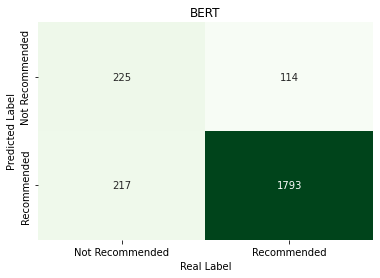

In [ ]:
# bert confusion matrix
import pandas as pd
df = pd.read_csv('test.csv')
y_pred, y_test = df['y_pred'],df['y_true']
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
cm = confusion_matrix(y_pred, y_test)
df = pd.DataFrame(cm, columns=["Not Recommended", "Recommended"], index= ["Not Recommended", "Recommended"])
df.index.name = "Predicted Label"
df.columns.name = "Real Label"
plt.title('BERT')
sns.heatmap(df, annot = True, cmap="Greens",cbar=False,fmt='g',);
plt.show()
# return np.reshape(test_vec, (-1, 1)), clf

In [ ]:
def evaluate_baseline(test_vec, y_test, clf, model_name):
  model_name += '(Tuned)'
  start = time.time()
  clf.fit(train_emotion_total, y_train_total)
  end = time.time()
  y_pred = clf.predict(test_vec)
  # p, r, fscore, acc = evaluate_p_r_f1_acc(y_pred, y_test)
  # print('Precision: ', round(100*p, 3), '\tRecall: ', round(100*r, 3), '\tF-score: ', round(100*fscore, 3), '\tacc: ', round(100*acc, 3), "\tTraining time: ")
  # metrics.plot_roc_curve(clf, test_vec, y_test, name=model_name)
  # plt.show()

  cm = confusion_matrix(y_pred, y_test)
  df = pd.DataFrame(cm, columns=["Not Recommended", "Recommended"], index= ["Not Recommended", "Recommended"])
  df.index.name = "Predicted Label"
  df.columns.name = "Real Label"
  plt.title(model_name)
  sns.heatmap(df, annot = True, cmap="Greens",cbar=False, fmt='g');
  plt.yticks(rotation=90, fontsize = 12) 
  plt.show()
  return np.reshape(test_vec, (-1, 1)), clf

In [ ]:
def preprocess_experiment(model_name, model):
  # print("stop-words + emotion + Clothing Count + one-hot for categorical features:")
  return evaluate_baseline(test_emotion_total, y_test_total, model, model_name)

In [ ]:
def tuned_vs_untuned(models, best_models):
  plt.rcParams["figure.figsize"] = (6.5,6.5)
  for model in models:
    clf = models[model]
    clf.fit(train_emotion_total, y_train_total)
    y_pred = clf.predict(test_emotion_total)
    p, r, fscore, acc = evaluate_p_r_f1_acc(y_pred, y_test_total)
    print('Precision: ', round(100*p, 3), '\tRecall: ', round(100*r, 3), '\tF-score: ', round(100*fscore, 3), '\tacc: ', round(100*acc, 3), "\tTraining time: ")
    model_name = model + "(Untuned)"
    best_curve = plot_roc_curve(clf, test_emotion_total, y_test_total, name=model_name)

    clf = best_models[model]
    clf.fit(train_emotion_total, y_train_total)
    y_pred = clf.predict(test_emotion_total)
    p, r, fscore, acc = evaluate_p_r_f1_acc(y_pred, y_test_total)
    print('Precision: ', round(100*p, 3), '\tRecall: ', round(100*r, 3), '\tF-score: ', round(100*fscore, 3), '\tacc: ', round(100*acc, 3), "\tTraining time: ")
    model_name = model + "(Tuned)"
    curve = plot_roc_curve(clf, test_emotion_total, y_test_total, name=model_name, ax=best_curve.ax_)
    plt.show()

Precision:  97.363 	Recall:  83.341 	F-score:  89.808 	acc:  82.163 	Training time: 
Precision:  97.363 	Recall:  83.379 	F-score:  89.83 	acc:  82.205 	Training time: 


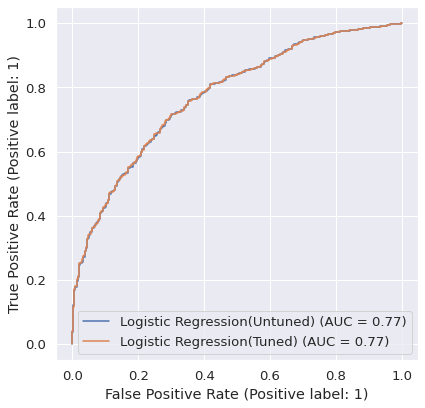

Precision:  84.335 	Recall:  84.424 	F-score:  84.38 	acc:  74.798 	Training time: 
Precision:  96.203 	Recall:  84.366 	F-score:  89.897 	acc:  82.546 	Training time: 


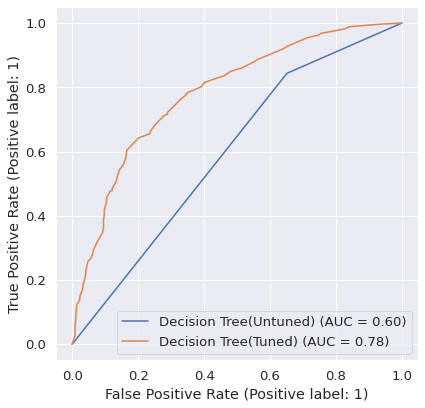

Precision:  95.939 	Recall:  84.802 	F-score:  90.027 	acc:  82.844 	Training time: 
Precision:  96.888 	Recall:  84.576 	F-score:  90.315 	acc:  83.227 	Training time: 


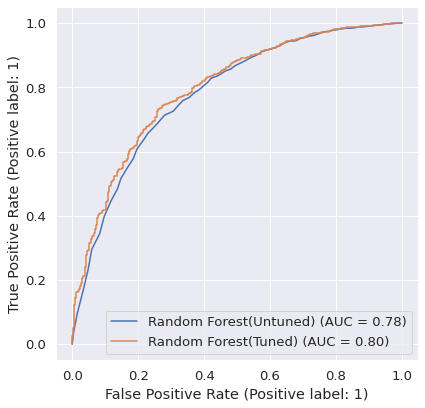

Precision:  96.572 	Recall:  84.261 	F-score:  89.998 	acc:  82.673 	Training time: 
Precision:  97.099 	Recall:  83.949 	F-score:  90.046 	acc:  82.673 	Training time: 


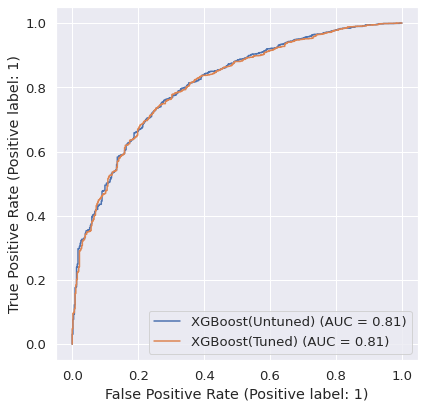

Precision:  95.886 	Recall:  84.48 	F-score:  89.822 	acc:  82.461 	Training time: 
Precision:  97.627 	Recall:  83.87 	F-score:  90.227 	acc:  82.929 	Training time: 


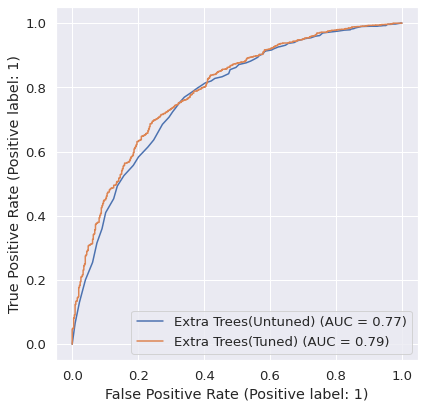

Precision:  100.0 	Recall:  80.715 	F-score:  89.329 	acc:  80.715 	Training time: 
Precision:  100.0 	Recall:  80.715 	F-score:  89.329 	acc:  80.715 	Training time: 


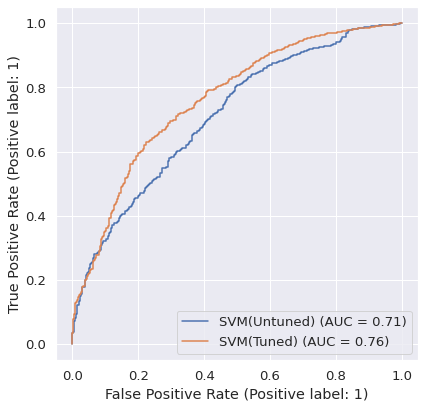

Precision:  94.778 	Recall:  84.565 	F-score:  89.381 	acc:  81.822 	Training time: 
Precision:  96.677 	Recall:  83.546 	F-score:  89.633 	acc:  81.95 	Training time: 


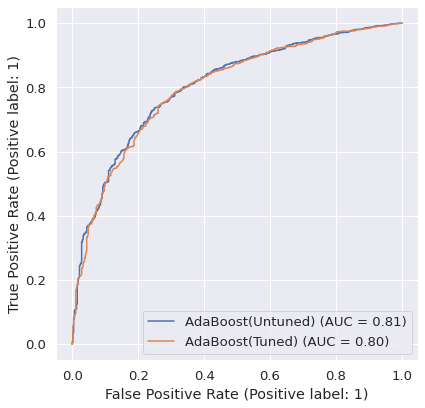

Precision:  91.35 	Recall:  86.341 	F-score:  88.775 	acc:  81.354 	Training time: 
Precision:  95.517 	Recall:  84.154 	F-score:  89.476 	acc:  81.865 	Training time: 


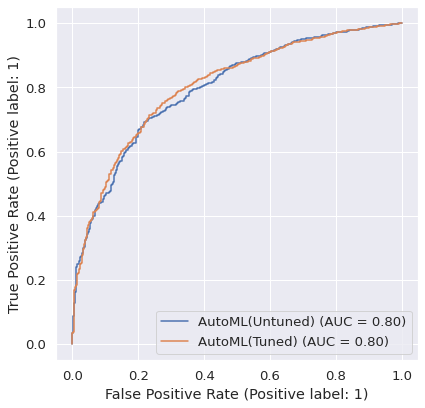

In [ ]:
tuned_vs_untuned(models, best_models)

Current Algorithm: Logistic Regression
LogisticRegression(C=10)


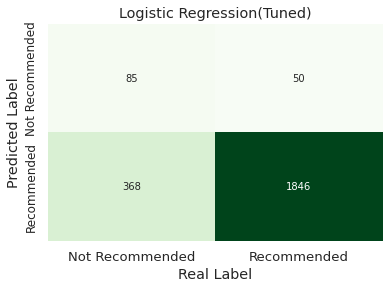

Current Algorithm: Decision Tree
DecisionTreeClassifier(min_samples_split=500, min_weight_fraction_leaf=0.001,
                       splitter='random')


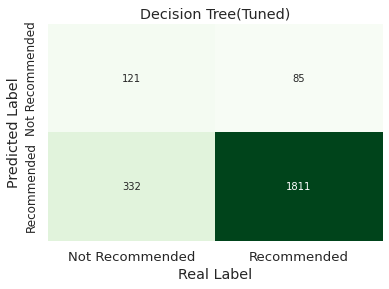

Current Algorithm: Random Forest
RandomForestClassifier(max_depth=50, min_samples_split=10, n_estimators=500)


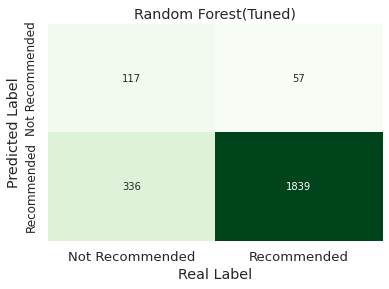

Current Algorithm: XGBoost
XGBClassifier(learning_rate=0.05, min_child_weight=5, missing=nan)


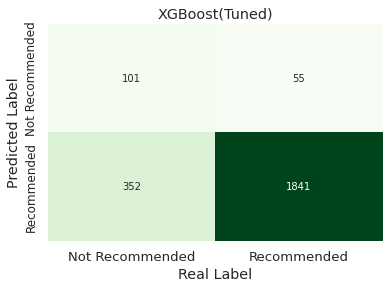

Current Algorithm: Extra Trees
ExtraTreesClassifier(min_samples_split=10, n_estimators=200)


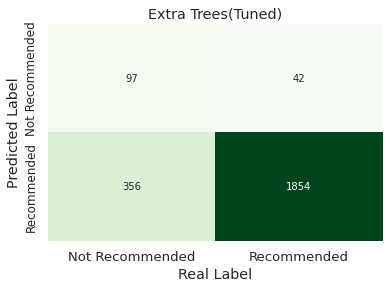

Current Algorithm: SVM
SVC(C=10, kernel='poly')


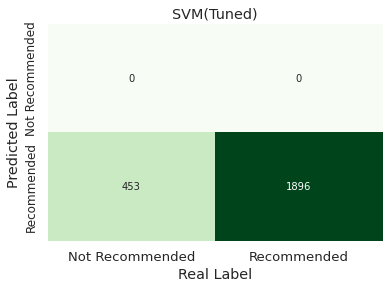

Current Algorithm: AdaBoost
AdaBoostClassifier(learning_rate=0.1, n_estimators=100)


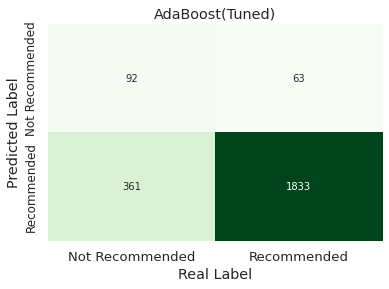

Current Algorithm: AutoML
AutoSklearn2Classifier(time_left_for_this_task=180)


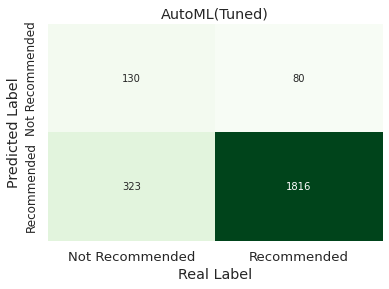

In [ ]:
save_models = []
for model in models:
  print("Current Algorithm:", model)
  clf = load('/content/gdrive/Shareddrives/520_Project/models/'+model+'.joblib')
  print(clf)
  y_hat, clf = preprocess_experiment(model, clf)
  save_models.append(clf)

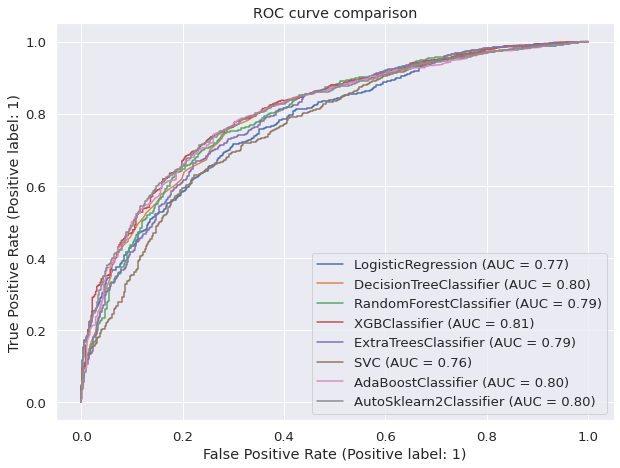

In [ ]:
svc_disp = plot_roc_curve(save_models[0], test_emotion_total, y_test_total)
for i in range(len(save_models) - 1):
  rfc_disp = plot_roc_curve(save_models[i + 1], test_emotion_total, y_test_total, ax=svc_disp.ax_)
plt.title("ROC curve comparison")
plt.rcParams["figure.figsize"] = (10, 7)
plt.show()

<class 'pandas.core.series.Series'>
['Division_0', 'Division_1', 'Division_2', 'Division_3', 'Department_0', 'Department_1', 'Department_2', 'Department_3', 'Department_4', 'Department_5', 'Department_6', 'Class_0', 'Class_1', 'Class_2', 'Class_3', 'Class_4', 'Class_5', 'Class_6', 'Class_7', 'Class_8', 'Class_9', 'Class_10', 'Class_11', 'Class_12', 'Class_13', 'Class_14', 'Class_15', 'Class_16', 'Class_17', 'Class_18', 'Class_19', 'Class_20', 'Clothing ID', 'Clothing Count', 'Review Text Length', 'Age', 'Positive Feedback Count', 'Emotion']


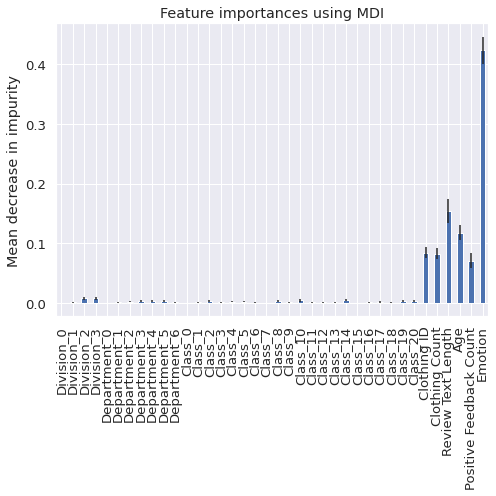

In [97]:
import pandas as pd
features = all_cols + ['Emotion']
importances = save_models[2].feature_importances_
std = np.std([tree.feature_importances_ for tree in save_models[2].estimators_], axis=0)
plt.rcParams["figure.figsize"] = (7, 7)
feature_names = [i for i in range(len(importances))]
forest_importances = pd.Series(importances, index=features)
print(type(forest_importances))
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")

fig.tight_layout()
print(features)

In [80]:
print("Total number of features:", len(features))
print("Feature names:")
for i in range(len(features) // 10):
  print(features[10*i:10*(i+1)])
print(features[10*(i+1):])

Total number of features: 38
Feature names:
['Division_0', 'Division_1', 'Division_2', 'Division_3', 'Department_0', 'Department_1', 'Department_2', 'Department_3', 'Department_4', 'Department_5']
['Department_6', 'Class_0', 'Class_1', 'Class_2', 'Class_3', 'Class_4', 'Class_5', 'Class_6', 'Class_7', 'Class_8']
['Class_9', 'Class_10', 'Class_11', 'Class_12', 'Class_13', 'Class_14', 'Class_15', 'Class_16', 'Class_17', 'Class_18']
['Class_19', 'Class_20', 'Clothing ID', 'Clothing Count', 'Review Text Length', 'Age', 'Positive Feedback Count', 'Emotion']
